# Classificação binária brest cancer com validação cruzada e dropout

In [1]:
!pip install skorch # == Pytorch + Sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 2.5 MB/s eta 0:00:00


### Importando Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import skorch    # para validacao cruzada
from skorch import NeuralNetBinaryClassifier
import torch
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score

In [3]:
torch.__version__, skorch.__version__, sklearn.__version__

('2.0.0+cu118', '0.12.1', '1.2.2')

### Base de dados

In [5]:
np.random.seed(123)
torch.manual_seed(123)

In [6]:
previsores = pd.read_csv('entradas_breast.csv')
classe = pd.read_csv('saidas_breast.csv')

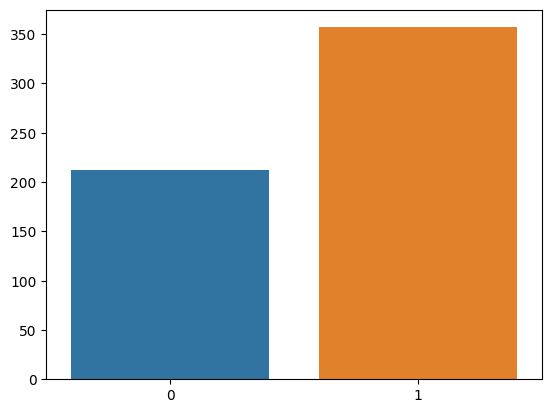

In [8]:
counts = classe['0'].value_counts()

# criar o gráfico de barras usando seaborn
sns.barplot(x=counts.index, y=counts.values);

In [9]:
classe.shape

(569, 1)

In [10]:
previsores = np.array(previsores, dtype='float32')
classe = np.array(classe, dtype='float32').squeeze(1)

In [11]:
classe.shape

(569,)

In [12]:
type(previsores)

numpy.ndarray

In [13]:
type(classe)

numpy.ndarray

### Classe para estrutura da rede neural

In [15]:
class classificador_torch(nn.Module):
  def __init__(self):
    super().__init__()

    # 30 -> 16 -> 16 -> 1
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight)
    self.activation0 = nn.ReLU()
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)
    # self.output = nn.Sigmoid() ** ATUALIZAÇÃO (ver detalhes no texto acima) **

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dense2(X)
    # X = self.output(X) ** ATUALIZAÇÃO (ver detalhes no texto acima) **
    return X

### Skorch

In [16]:
classificador_sklearn = NeuralNetBinaryClassifier(module=classificador_torch,
                                                  criterion=torch.nn.BCEWithLogitsLoss, # ** ATUALIZAÇÃO **
                                                  optimizer=torch.optim.Adam,
                                                  lr=0.001,
                                                  optimizer__weight_decay=0.0001,
                                                  max_epochs=100,
                                                  batch_size=10,
                                                  train_split=False)

### Validação cruzada

In [17]:
resultados = cross_val_score(classificador_sklearn, previsores, classe, cv = 10, scoring = 'accuracy') # dados no formato de numpy array

  epoch    train_loss     dur
-------  ------------  ------
      1   107325.7548  0.6098
      2    86254.6303  0.2836
      3    68469.2027  0.1774
      4    53957.7557  0.1437
      5    42087.0206  0.1158
      6    32326.2660  0.1773
      7    24257.5120  0.1359
      8    17518.0686  0.0771
      9    11790.4187  0.0734
     10     6781.5139  0.0793
     11     2218.8343  0.0939
     12      192.7413  0.0763
     13      166.0516  0.0764
     14      142.9409  0.0759
     15      125.7514  0.0810
     16      106.8138  0.0766
     17       91.1450  0.0787
     18       85.3341  0.0785
     19       73.7283  0.0811
     20       69.8900  0.0756
     21       52.9702  0.0916
     22       59.5451  0.0743
     23       50.3248  0.0837
     24       47.4435  0.0879
     25       46.8926  0.0840
     26       46.3667  0.0840
     27       51.4423  0.0829
     28       44.0096  0.0818
     29       40.9110  0.0776
     30       42.7534  0.0769
     31       41.2551  0.0827
     32   

In [18]:
resultados.shape

(10,)

In [19]:
resultados

array([0.75438596, 0.84210526, 0.8245614 , 0.9122807 , 0.9122807 ,
       0.85964912, 0.87719298, 0.8245614 , 0.77192982, 0.78571429])

In [25]:
media = resultados.mean() # mostra a media dos resultados
media

0.8364661654135338

In [26]:
desvio = resultados.std() # desvio padrao amostral
desvio

0.052426051743756745

### Dropout -> Para evitar overfitting (tem um bom resultado em treinamento e resultado ruim em teste)

In [27]:
class classificador_torch(nn.Module):
  def __init__(self):
    super().__init__()

    # 30 -> 16 -> 16 -> 1
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight)
    self.activation0 = nn.ReLU()
    self.dropout0 = nn.Dropout(0.2)
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.2)
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)
    # self.output = nn.Sigmoid() ** ATUALIZAÇÃO **

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dropout0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dropout1(X)
    X = self.dense2(X)
    # X = self.output(X) ** ATUALIZAÇÃO **
    return X

In [28]:
classificador_sklearn = NeuralNetBinaryClassifier(module=classificador_torch,
                                                  criterion=torch.nn.BCEWithLogitsLoss, # ** ATUALIZAÇÃO **
                                                  optimizer=torch.optim.Adam,
                                                  lr=0.001,
                                                  optimizer__weight_decay=0.0001,
                                                  max_epochs=100,
                                                  batch_size=10,
                                                  train_split=False)

In [29]:
resultados = cross_val_score(classificador_sklearn, previsores, classe, cv = 10, scoring = 'accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1    76826.3913  0.0985
      2    60939.8427  0.0836
      3    48414.3305  0.0937
      4    36653.4982  0.0817
      5    28375.0036  0.0827
      6    21817.1026  0.0867
      7    16252.4861  0.0851
      8    11266.8603  0.0851
      9     7430.2986  0.0929
     10     4148.7800  0.0965
     11     2851.8537  0.0930
     12     2349.3630  0.0869
     13     2574.3616  0.0844
     14     2280.8980  0.0856
     15     1909.6453  0.0865
     16     1792.1118  0.0921
     17     1636.7897  0.0902
     18     1475.0408  0.0871
     19     1628.6915  0.0851
     20     1758.2286  0.0825
     21     1512.2896  0.0880
     22     1185.2867  0.0979
     23     1009.3950  0.0842
     24     1060.6702  0.0852
     25     1212.9753  0.0860
     26      966.5796  0.0889
     27      882.4842  0.0911
     28      844.1321  0.0843
     29      831.6535  0.0929
     30      682.6996  0.0869
     31      725.7147  0.0847
     32   

In [30]:
media = resultados.mean()
desvio = resultados.std()
media, desvio

(0.6102130325814535, 0.10632093614467122)

In [31]:
resultados

array([0.68421053, 0.54385965, 0.59649123, 0.66666667, 0.64912281,
       0.61403509, 0.43859649, 0.63157895, 0.45614035, 0.82142857])

O artigo "Dropout - A Simple Way to Prevent Neural Networks from Overfitting" (Desistência - Uma Maneira Simples de Prevenir o Overfitting em Redes Neurais) foi escrito por Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever e Ruslan Salakhutdinov e publicado em 2014. O artigo introduziu um método chamado Dropout, que se tornou uma técnica popular para lidar com o overfitting em redes neurais.

O overfitting ocorre quando uma rede neural se ajusta muito bem aos dados de treinamento, mas não generaliza bem para novos dados. Isso pode levar a um desempenho ruim em tarefas de teste ou aplicação prática. O Dropout é uma técnica de regularização que aborda esse problema, reduzindo a complexidade da rede neural e evitando a dependência excessiva de neurônios específicos.

O Dropout funciona desativando aleatoriamente um conjunto de neurônios durante o treinamento. Em cada etapa do treinamento, um neurônio tem uma probabilidade definida de ser desativado. Isso faz com que a rede neural tenha que aprender a trabalhar com diferentes subconjuntos de neurônios em cada iteração, o que reduz a dependência de neurônios individuais e promove a generalização.

A principal intuição por trás do Dropout é que, ao desligar aleatoriamente neurônios durante o treinamento, a rede neural se torna mais robusta e evita depender de interações complexas entre neurônios específicos. Isso ajuda a evitar o overfitting, pois a rede se torna mais capaz de generalizar padrões aprendidos em um conjunto de treinamento para novos dados.

O artigo também discute a implementação do Dropout em diferentes tipos de camadas de redes neurais, como camadas totalmente conectadas e camadas convolucionais. Também são abordadas questões práticas, como a determinação da probabilidade de dropout adequada para cada camada.

Os autores realizaram experimentos em várias tarefas de classificação, como reconhecimento de dígitos escritos à mão e classificação de imagens, e mostraram que o Dropout é eficaz na redução do overfitting e melhora o desempenho das redes neurais. Além disso, eles compararam o Dropout com outras técnicas de regularização existentes e demonstraram que o Dropout supera muitas delas em termos de desempenho.

Em resumo, o artigo "Dropout - A Simple Way to Prevent Neural Networks from Overfitting" introduziu o Dropout como uma técnica eficaz para evitar o overfitting em redes neurais. Essa abordagem desativa aleatoriamente neurônios durante o treinamento, promovendo a generalização e reduzindo a dependência de neurônios específicos. O Dropout provou ser uma ferramenta valiosa para melhorar o desempenho de redes neurais em uma variedade de tarefas de aprendizado de máquina.